In [1]:
%matplotlib inline

Formalizing Data Processing
=======================================

**Suhas Somnath**

4/26/2018

**In this example, we will learn how to write a simple yet formal pycroscopy class for processing data.**

Introduction
------------
Most of code written for scientific research is in the form of single-use / one-off scripts due to a few common reasons:
* the author feels that it is the fastest mode to accomplishing a research task 
* the author feels that they are unlikely to perform the same operation again 
* the author does not anticipate the possibility that others may need to run their code

However, more often than not, nearly all researchers have found that one or more of these assumptions fail and a lot of time is spent on fixing bugs and generalizing / formalizing code such that it can be shared or reused. Moreover, we live in an era of open science where the scientific community and an ever-increasing number of scientific journals are moving towards a paradigm where the data and code need to be made available with journal papers. Therefore, in the interest of saving time, energy, and reputation (you do not want to show ugly code / data. Instead you want to be the paragon of clean intellgible data and code), it makes a lot more sense to formalize (parts of) one's data analysis code.  

For many researchers, formalizing data processing or analysis may seem like a daunting task due to the complexity of and the number of sub-operations that need to performed. **pycroscopy.Process** greatly simplifies the process of formalizing code by lifting or reducing the burden of implementing important, yet tedious tasks and considerations such as:
* **memory management** - reading chunks of datasets that can be processed with the available memory, something very crcuial for very large datasets that cannot entirely fit into the computer's memory 
* **considerate CPU usage for parallel computing** - using all but one or two CPU cores for the (parallel) computation , which allows the user to continue using the computer for other activities such as reading mail, etc.
* **pausing and resuming computation** - interrupting and resuming the computation at a more convenient time, something that is especially valuable for lengthy computations.
* **avoiding repeated computation and returning existing results** - pycroscopy.Process will return existing results computed using the exact same parameters instead of re-computing and storing duplicate copies of the same results.
* **testing before computation** - checking the processing / analysis on a single unit (typically a single pixel) of data before the entire data is processed. This is particularly useful for lengthy computations.

Using **pycroscopy.Process**, the user only needs to address the following basic operations:
1. Reading data from file
2. Computation on a single unit of data
3. Writing results to disk


Components of pycroscopy.Process
-----------------------------------
The most important functions in the Process class are:
* **__init__()** - instantiates a 'Process' object of this class after validating the inputs.
* **_create_results_datasets()** - creates the HDF5 datasets and Group(s) to store the results.
* **_map_function()** - the operation that will per be performed on each element in the dataset.
* **test()** - This simple function lets the user test the **map_function** on a unit of data (a single pixel / spectra in this case) to see if it returns the desired results. It saves a lot of computational time by allowing the user to spot-check results before computing on the entire dataset
* **_read_data_chunk()** - reads the input data from one or more datasets.
* **_write_results_chunk()** - writes the computed results back to the file
* **_unit_computation()** - Defines how to process a chunk (multiple units) of data. This allows room for pre-processing of input data and post-processing of results if necessary. If neither are required, this function essentially appliest parallel computation on _map_function().
* **compute()** - this does the bulk of the work of (iteratively) reading a chunk of data >> processing in parallel via _unit_computation() >> calling write_results_chunk() to write data. Most sub-classes, including the one below, do not need to extend / modify this function.

Recommended pre-requisite reading
---------------------------------
* pycroscopy data format - https://pycroscopy.github.io/pycroscopy/data_format.html.
* Crash course on HDF5 and h5py - 
* Utilities for reading and writing HDF5 files in pycroscopy.hdf_utils
* Crash course on Parallel processing

Example problem
---------------
For this example, we will be working with a Band Excitation Piezoresponse Force Microscopy (BE-PFM) imaging dataset
acquired from advanced atomic force microscopes. In this dataset, a spectra was collected for each position in a two
dimensional grid of spatial locations. Thus, this is a three dimensional dataset that has been flattened to a two
dimensional matrix in accordance with the pycroscopy data format.

This example is based on the parallel computing primer where we searched for the peak of each spectra in a dataset. While that example focused on comparing serial and parallel computing, we will focus on demonstrating the simplicity with which such a data analysis algorithm can be formalized. 

This example is a simplification of the pycroscopy.analysis.BESHOFitter class. 

Import necessary packages
-------------------------

In [2]:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os

# Warning package in case something goes wrong
from warnings import warn

# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    pip.main(['install', 'wget'])
    import wget

# The mathematical computation package:
import numpy as np
from numpy import exp, abs, sqrt, sum, real, imag, arctan2, append

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Finally import pycroscopy for certain scientific analysis:
if True:
    import sys
    sys.path.append(os.path.split(os.path.abspath('.'))[0])
    import pycroscopy as px
else:
    try:
        import pycroscopy as px
    except ImportError:
        warn('pycroscopy not found.  Will install with pip.')
        import pip
        pip.main(['install', 'pycroscopy'])
        import pycroscopy as px

//anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/syz/PycharmProjects/pycroscopy/pycroscopy/__init__.py:25: UserWarning: You are using the unity_dev branch, which is aimed at a 1.0 release for pycroscopy. Be advised - this branch changes very significantly and frequently. Use the master or dev branches for regular purposes.
  warn('You are using the unity_dev branch, which is aimed at a 1.0 release for pycroscopy. '


The goal is to **find the amplitude at the peak in each spectra**. Clearly, the operation of finding the peak in one spectra is independent of the same operation on another spectra. Thus, we could divide the dataset in to N parts and use N CPU cores to compute the results much faster than it would take a single core to compute the results. Such problems are ideally suited for making use of all the advanced functionalities in the Process class.

Defining the Process class
===============
In order to solve our problem, we would need to implement a **sub-class** of pycroscopy.Process or in other words - **extend pycroscopy.Process**. As mentioned above, the pycroscopy.Process class already generalizes several important components of data processing. We only need to extend this class by implementing the science-specific functionality. The rest of the capabilities will be **inherited** from pycroscopy.Process.  

Lets think about what operations need be performed for each of the core Process functions listed above.

map_function()
--------------
The most important component in our new Process class is the unit computation that needs to be performed on each spectra. **map_function()** needs to take as input a single spectra and return the amplitude at the peak (a single value). The **compute()** and **unit_computation()** will handle the parallelization.

Pycroscopy already has a function called wavelet_peaks() that facilitates the seach for one or more peaks in a spectra located in pycroscopy.analysis.guess_methods. The exact methodolody for finding the peaks is not of interest for this particular example. However, this function only finds the index of one or more peaks in the spectra. We only expect one peak at the center of the spectra. Therefore, we can use the wavelet_peaks() function to find the peaks and address those situations when too few or too many (> 1) peaks are found in a single spectra. Finally, we need to use the index of the peak to find the amplitude from the spectra.

test()
------
A useful test function should be able to find the peak amplitude for any single spectra in the dataset. So, given the index of a pixel (provided by the user), we should perform two operations:
* read the spectra corresponding to that index from the HDF5 dataset
* apply the **map_function()** to this spectra and return the result.

create_results_datasets()
------------------------
Every Process involves a few tasks for this function:
* the creation of a HDF5 group to hold the datasets containing the results - pycroscopy.hdf_utils has a handy function that takes care of this.
* storing any relevant metadata regarding this processing as attributes of the HDF5 group for provenance, traceability, and reproducability.
    * 'last_pixel' is a reserved attribute that serves as a flag indicating the last pixel that was successfully processed and written to the results dataset. This attribute is key for resuming partial computations.
* the creation of HDF5 dataset(s) to hold the results. **map_function()** takes a spectra (1D array) and returns the amplitude (a single value). Thus the input dataset (position, spectra) will be reduced to (position, 1). So, we only need to create a single empty dataset to hold the results.
We just need to ensure that we have a reference to the results dataset so that we can populate it with the results.

write_results_chunk()
--------------------
The result of **compute()** will be a list of amplitude values. All we need to do is:
* write the results into the HDF5 dataset
* Set the **last_pixel** attribute to the value of the **end_pos** internal variable to indicate that pixels upto **end_pos** were succesfully processed. Should the computation be interrupted after this point, we could resume from **end_pos** instead of starting from **0** again. 
* update the **start_pos** internal variable to guide compute() to process the next batch of positions / pixels

In [3]:
class PeakFinder(px.Process):
        
    def test(self, pixel_ind):
        """
        Test the algorithm on a single pixel
        
        Parameters
        ----------
        pixel_ind : uint
            Index of the pixel in the dataset that the process needs to be tested on.
        """
        # First read the HDF5 dataset to get the spectra for this pixel
        spectra = self.h5_main[pixel_ind]
        # Next, apply the map function to the spectra. done!
        return self._map_function(spectra)

    def _create_results_datasets(self):
        """
        Creates the datasets an Groups necessary to store the results.
        There are only THREE operations happening in this function:
        1. Creation of HDF5 group to hold results
        2. Writing relevant metadata to this HDF5 group
        3. Creation of a HDF5 dataset to hold results
        
        Please see examples on utilities for writing pycroscopy HDF5 files for more information
        """
        self.process_name = 'Peak_Finding'
        
        # 1. create a HDF5 group to hold the results
        self.h5_results_grp = px.hdf_utils.create_results_group(self.h5_main, self.process_name)
        
        # 2. Write relevant metadata to the group
        px.hdf_utils.write_simple_attrs(self.h5_results_grp, 
                                        {'last_pixel': 0, 'algorithm': 'wavelet_peaks'})       
        
        # Explicitely stating all the inputs to write_main_dataset
        # The process will reduce the spectra at each position to a single value
        # Therefore, the result is a 2D dataset with the same number of positions as self.h5_main
        results_shape = (self.h5_main.shape[0], 1)
        results_dset_name = 'Peak_Response'
        results_quantity = 'Amplitude'
        results_units = 'V'
        pos_dims = None # Reusing those linked to self.h5_main
        spec_dims = px.write_utils.Dimension('Empty', 'a. u.', 1)
        
        
        # 3. Create an empty results dataset that will hold all the results
        self.h5_results = px.hdf_utils.write_main_dataset(self.h5_results_grp, results_shape, results_dset_name, 
                                                          results_quantity, results_units, pos_dims, spec_dims, 
                                                          dtype=np.float32,
                                                          h5_pos_inds=self.h5_main.h5_pos_inds,
                                                          h5_pos_vals=self.h5_main.h5_pos_vals)
        # Note that this function automatically creates the ancillary datasets and links them.
        
        print('Finshed creating datasets')
    
    def _write_results_chunk(self):
        """
        Write the computed results back to the H5
        In this case, there isn't any more additional post-processing required
        """            
        # write the results to the file 
        self.h5_results[:, 0] = np.array(self._results)
        
        # Flush the results to ensure that they have indeed been written to the file
        self.h5_main.file.flush()
        
        # update the 'last_pixel' to indicate that the process was succesfully completed on this many positions:
        self.h5_results_grp.attrs['last_pixel'] = self._end_pos

        # Now update the start position
        self._start_pos = self._end_pos       

    @staticmethod
    def _map_function(spectra, *args, **kwargs):
        """
        This is the function that will be applied to each pixel in the dataset.
        It's job is to demonstrate what needs to be done for each pixel in the dataset.
        pycroscopy.Process will handle the parallel computation and memory management
        
        As in typical scientific problems, the results from wavelet_peaks() need to be
        post-processed
        
        In this case, the wavelet_peaks() function can sometimes return 0 or more than one peak
        for spectra that are very noisy
        
        Knowing that the peak is typically at the center of the spectra,
        we return the central index when no peaks were found
        Or the index closest to the center when multiple peaks are found
        
        Finally once we have a single index, we need to index the spectra by that index
        in order to get the amplitude at that frequency.
        """
        
        peak_inds = px.analysis.guess_methods.GuessMethods.wavelet_peaks(spectra, peak_widths=[20, 60], peak_step=30)
        
        central_ind = len(spectra) // 2
        if len(peak_inds) == 0: 
            # too few peaks
            # set peak to center of spectra
            val = central_ind
        elif len(peak_inds) > 1:
            # too many peaks
            # set to peak closest to center of spectra
            dist = np.abs(peak_inds - central_ind)
            val = peak_inds[np.argmin(dist)]
        else:
            # normal situation
            val = peak_inds[0]
        return np.abs(spectra[val])

Comments
---------
* The class appears to be large mainly because of comments that explain what each line of code is doing.
* Several functions of pycroscopy.Process such as __init__() and **compute()** were inherited from the pycroscopy.Process class.
* In simple cases such as this, we don't even have to implement a function to read the data from the dataset since pycroscopy.Process automatically calculates how much of the data iss safe to load into memory. In this case, the dataset is far smaller than the computer memory, so the entire dataset can be loaded and processed at once.
* In this example, we did not need any pre-processing or post-processing of results but those can be implemented too if necessary
* The majority of the code in this class would have to be written regardless of whether the intention is formalize the data processing or not. In fact, we would argue that **more** code may need to be written than what is shown below if one were **not** formalizing the data processing (data reading, parallel computing, memory management, etc.)
* This is the simplest possible implementation of Process. Certain features such as checking for existing results and resuming partial computations have not been shown in this example.

Using this Process class
================
Now that the class has been written, it can be applied to an actual dataset.

Load the dataset
----------------
In order to demonstrate this Process class, we will be using a real experimental dataset that is available on the pycroscopy GitHub project. First, lets download this file from Github:

In [4]:
# download the raw data file from Github:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/data/BELine_0004.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Lets open the file in an editable (r+) mode and look at the contents:

In [10]:
# Open the file in editable mode
#h5_file = h5py.File(h5_path, mode='r+')
print('File contents:\n')
px.hdf_utils.print_tree(h5_file)

File contents:

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Peak_Finding_000
      -------------------------
      ├ Peak_Response
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices


The focus of this example is not on the data storage or formatting but rather on demonstrating our new Process class so lets dive straight into the main dataset that requires analysis of the spectra:

In [5]:


h5_chan_grp = h5_file['Measurement_000/Channel_000']

# Accessing the dataset of interest:
h5_main = px.PycroDataset(h5_chan_grp['Raw_Data'])
print('\nThe main dataset:\n------------------------------------')
print(h5_main)

# Extract some metadata:
num_rows, num_cols = h5_main.pos_dim_sizes
freq_vec = h5_main.get_spec_values('Frequency') * 1E-3


The main dataset:
------------------------------------
<HDF5 dataset "Raw_Data": shape (16384, 119), type "<c8">
located at: 
/Measurement_000/Channel_000/Raw_Data 
Data contains: 
[''] (['a']) 
Data dimensions and original shape: 
Position Dimensions: 
X - size: 128 
Y - size: 128 
Spectroscopic Dimensions: 
Frequency - size: 119


Use the Process class
============

Instantiation
-------------
Note that the instantiation of the new PeakFinder Process class only requires that we supply the main dataset on which the computation will be performed:

In [6]:
fitter = PeakFinder(h5_main)

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file


test()
------
As advised, lets test the PeakFinder on an example pixel:

In [7]:
row_ind, col_ind = 103, 19
pixel_ind = col_ind + row_ind * num_cols

# Testing is as simple as supplying a pixel index
amplitude = fitter.test(pixel_ind)

Now, let's visualize the results of the test:

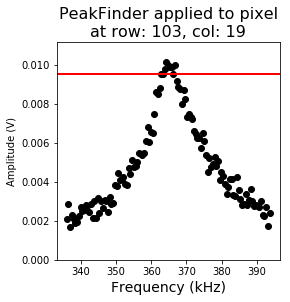

In [8]:
spectra = h5_main[pixel_ind]

fig, axis = plt.subplots(figsize=(4, 4))
axis.scatter(freq_vec, np.abs(spectra), c='black')
axis.axhline(amplitude, color='r', linewidth=2)
axis.set_xlabel('Frequency (kHz)', fontsize=14)
axis.set_ylabel('Amplitude (V)')
axis.set_ylim([0, 1.1 * np.max(np.abs(spectra))])
axis.set_title('PeakFinder applied to pixel\nat row: {}, col: {}'.format(row_ind, col_ind), fontsize=16);

If we weren't happy with the results, we could tweak some parameters when initializing the PeakFinder object and try again. However, for the sake of simplicity, we don't have any parameters we can / want to adjust in this case. So, lets proceed.

compute()
---------
Now that we know that the PeakFitter appears to be performing as expected, we can apply the amplitude finding operation to the entire dataset using the compute() function. The result is the HDF5 dataset containing the results.

In [9]:
h5_results_grp = fitter.compute()
print(h5_results_grp)

Finshed creating datasets
You maybe able to abort this computation at any time and resume at a later time!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
Finished parallel computation
Completed computation on chunk. Writing to file.
<HDF5 group "/Measurement_000/Channel_000/Raw_Data-Peak_Finding_000" (3 members)>


Lets take a look again at the file contents. We should be seeing a new group called Raw_Data-Peak_Finding_000 and three datasets within the group. Among the datasets is 'Peak_Response' that contains the peak amplitudes we are interested in.

In [11]:
px.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Peak_Finding_000
      -------------------------
      ├ Peak_Response
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices


Lets look at this 'Peak_Response' dataset:

In [14]:
h5_peak_amps = px.PycroDataset(h5_results_grp['Peak_Response'])
print(h5_peak_amps)

<HDF5 dataset "Peak_Response": shape (16384, 1), type "<f4">
located at: 
/Measurement_000/Channel_000/Raw_Data-Peak_Finding_000/Peak_Response 
Data contains: 
Amplitude (V) 
Data dimensions and original shape: 
Position Dimensions: 
X - size: 128 
Y - size: 128 
Spectroscopic Dimensions: 
Empty - size: 1


Visualize
---------
Since 'Peak_Response' is a PycroDataset, we could use its ability to provide its own N dimensional form:

In [16]:
amplitudes = np.squeeze(h5_peak_amps.get_n_dim_form())
print('N dimensional shape of Peak_Response: {}'.format(amplitudes.shape))

N dimensional shape of Peak_Response: (128, 128)


Finally, we can look at a map of the peak amplitude for the entire dataset:

Text(0.5,1,'Peak Amplitudes')

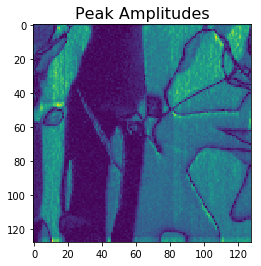

In [17]:
fig, axis = plt.subplots(figsize=(4, 4))
axis.imshow(amplitudes)
axis.set_title('Peak Amplitudes', fontsize=16)

Clean up
--------
Finally lets close and delete the example HDF5 file

In [18]:
h5_file.close()
os.remove(h5_path)

Advanced examples
-----------------
Please see the following pycroscopy classes to learn more about the advanced functionalities such as resuming computations, checking of existing results, etc.:
* pycroscopy.prcessing.SignalFilter
* pycroscopy.analysis.GIVBayesian